In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools


from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_18846/3719828106.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


imblearn version:  0.12.0


In [2]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def plot_tsne(input, y_true, n_components): 
    tsne = TSNE(n_components=n_components, random_state=42)
    embedded_data = tsne.fit_transform(input)
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=y_true, cmap='viridis')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Labels')
    plt.show();

In [4]:
def look_at_data(filepath):
    """5-fold on majority and minority separately, then concat into one df""" 
    df = pd.read_csv(filepath)

    print("Dataset shape:",df.shape)
    print(df.active.value_counts())
    print(df['fold'].unique())
    num_gap = (df.loc[df['active']==0].shape[0]) - (df.loc[df['active']==1].shape[0])
    print("\nDifference in class sample sizes: ",num_gap)

    num_minority = df.loc[df['active']==1].shape[0]
    print("Number of minority samples: ",num_minority)
    # print(df.describe())
    print(f"active/inactive: {df['active'].value_counts()}")
    print(f"active/inactive: {df['active'].value_counts()}")
    counts_per_fold = df.groupby('fold')['active'].value_counts()
    print(counts_per_fold)
    return df

In [5]:
split_path = '../../../data/NEK_data_4Berkeley/NEK2/'
file = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
all_fold_df = look_at_data(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

Dataset shape: (1408, 310)
active
0    1351
1      57
Name: count, dtype: int64
['fold4' 'fold1' 'fold2' 'fold3' 'fold5']

Difference in class sample sizes:  1294
Number of minority samples:  57
active/inactive: active
0    1351
1      57
Name: count, dtype: int64
active/inactive: active
0    1351
1      57
Name: count, dtype: int64
fold   active
fold1  0         271
       1          12
fold2  0         270
       1          12
fold3  0         270
       1          11
fold4  0         270
       1          11
fold5  0         270
       1          11
Name: count, dtype: int64


In [6]:
# train fold 1
split_path = "../../../data/datasets/NEK_data_4Berkeley/NEK2"
# /Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/NEK2_binding_random_fold1_testY.csv
train_x_df_temp = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
train_y_df_temp = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")

In [67]:
test_y_df.shape
train_x_df_temp.shape #1125 
# train_y_df_temp.shape 
# test_x_df.shape  #283 
# 1125+283

(1125, 306)

In [8]:
# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
new_train_x_df, new_train_y_df = oversample.fit_resample(train_x_df_temp, train_y_df_temp)

display(new_train_x_df.head)

display("original training size: ",train_x_df_temp.shape)
# display(train_y_df_temp.value_counts())
display("SMOTE train set size:",new_train_x_df.shape)
# display(new_train_y_df.value_counts())

<bound method NDFrame.head of       ASA+_per_atom        ASA-  ASA_H_per_atom       ASA_P  ASA_per_atom  \
0         14.897949   53.326256        8.903966  161.217960     17.860519   
1          8.496225  275.100830        8.517174  278.048280     13.229856   
2          6.791036  344.713500        8.136228  261.311580     12.350931   
3          7.619170  252.392720        8.119836  235.214870     13.346833   
4          9.629118  190.869540       11.334554  127.854520     14.530917   
...             ...         ...             ...         ...           ...   
2155       6.689095  250.062547        8.459925  120.238029     10.082696   
2156       7.991437  219.089428        7.884139  227.025504     11.084951   
2157       7.727019  279.551191        8.902547  192.562138     11.504738   
2158       7.675363  234.794732        8.087141  212.416611     12.571865   
2159       7.854434  204.199222        7.815318  203.157419     12.274510   

      BCUT_PEOE_0  BCUT_PEOE_1  BCUT_PEOE_2  

'original training size: '

(1125, 306)

'SMOTE train set size:'

(2160, 306)

In [43]:
# save to files 
train_x_df = new_train_x_df
train_y_df = new_train_y_df

train_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainX.csv", index=False)
train_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainY.csv", index=False)
test_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testX.csv", index=False)
test_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testY.csv", index=False)


In [44]:
indices = test_y_df.index[test_y_df['active'] == 1]
indices

Index([271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282], dtype='int64')

In [45]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df) 


train_x_temp = train_scaled_data.astype("long")
test_x_temp = test_scaled_data.astype("long")

train_y_temp = train_y_df.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")


train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape)
print(train_y.shape)

torch.Size([2160, 306])
torch.Size([2160])


In [46]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




In [47]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 

            

    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # get predicted distributions 
            pred_means = dist.loc          # extract means for each input 
            # pred_probs = self.likelihood(dist).probs #predicted probabilities 
            # f_mean = dist.mean
            # f_var = dist.variance
            # f_covar = dist.covariance_matrix
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood observed predictions 
            # f_preds = self.model(input)
            print(f'prediction means shape: {pred_means.numpy().shape}')
            print(f'class predictions: {pred_means.max(0)[1]}')
            # class_pred = pred_means.max(0)[1]
            class_pred = self.model(input).loc.max(0)[1].numpy()

        return observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true, class_names, plot_name): 
        y_pred = self.model(x_input).loc.max(0)[1].numpy() 

        cm = confusion_matrix(y_true, y_pred)
        plt.rcParams.update({"font.size": 20})
        label_font = {'size':'18'}  # Adjust to fit
        ax = plt.figure(figsize=(5,5))
        plt.title(plot_name,fontsize=20)
        plot_confusion_matrix(cm, classes=class_names, normalize=False)
        plt.xlabel("Predicted",fontdict=label_font);
        plt.ylabel("Actual",fontdict=label_font);
        return y_pred
    
    
    def get_metrics(self, x, y_true, y_pred): 
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x)     # get predicted distributions 
        pred_means = dist.loc          # extract means for each input 
            # pred_probs = self.likelihood(dist).probs #predicted probabilities 
        # f_mean = dist.mean
        # f_var = dist.variance
        # f_covar = dist.covariance_matrix
        # f_samples = dist.sample(sample_shape=torch.Size(1000))    
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        # # roc_auc = roc_auc_score(y_true, y_pred_proba) 
        # # fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
        # # roc_auc_curve = auc(fpr, tpr)
        # # precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
        # # pr_auc_curve = auc(recall, precision)
        
        
        return accuracy, precision, f1, recall 
            

In [48]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.041   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.757   lengthscale: 1.319   noise: 1.287
Iter 21/300 - Loss: 5.029   lengthscale: 2.199   noise: 1.825
Iter 31/300 - Loss: 4.610   lengthscale: 3.270   noise: 1.901
Iter 41/300 - Loss: 4.275   lengthscale: 4.326   noise: 1.500
Iter 51/300 - Loss: 3.985   lengthscale: 5.281   noise: 0.887
Iter 61/300 - Loss: 3.759   lengthscale: 6.044   noise: 0.403
Iter 71/300 - Loss: 3.644   lengthscale: 6.594   noise: 0.173
Iter 81/300 - Loss: 3.584   lengthscale: 6.972   noise: 0.089
Iter 91/300 - Loss: 3.544   lengthscale: 7.220   noise: 0.057
Iter 101/300 - Loss: 3.537   lengthscale: 7.376   noise: 0.041
Iter 111/300 - Loss: 3.526   lengthscale: 7.469   noise: 0.033
Iter 121/300 - Loss: 3.521   lengthscale: 7.525   noise: 0.027
Iter 131/300 - Loss: 3.526   lengthscale: 7.562   noise: 0.023
Iter 141/300 - Loss: 3.516   lengthscale: 7.589   noise: 0.020
Iter 151/300 - Loss: 3.503   lengthscale: 7.610   noise: 0.018
Ite

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


prediction means shape: (2, 2160)
class predictions: tensor([0, 0, 0,  ..., 1, 1, 1])
train predictions: [0 0 0 ... 1 1 1]
observed pred predictions: tensor([0, 0, 0,  ..., 1, 1, 1])


/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


accuracy: 0.999537037037037, precision: 0.9990749306197965, f1: 0.999537251272559, recall: 1.0


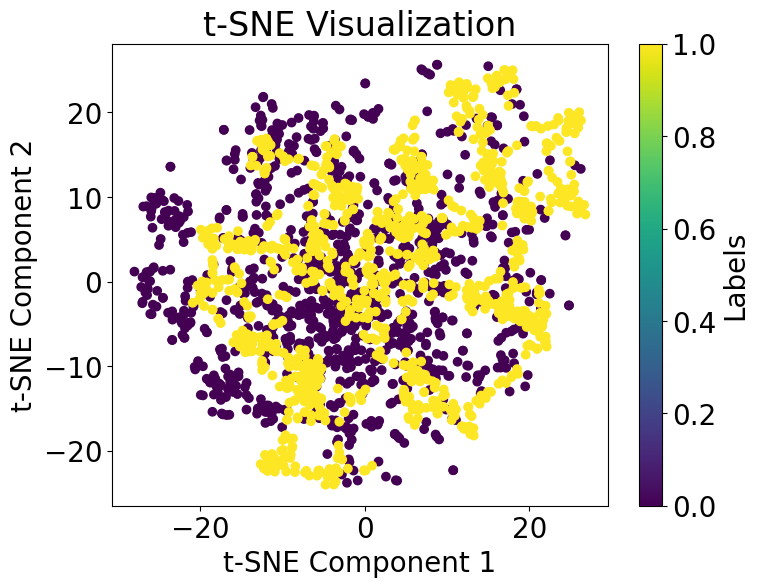

In [49]:
train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
# print(f'pred means shape: {train_pred_means.numpy().shape}')
print(f'train predictions: {train_pred}')
print(f'observed pred predictions: {train_observed_pred.loc.max(0)[1]}')
train_accuracy, train_precision, train_f1, train_recall = trainer1.get_metrics(train_x, train_y, train_pred)
print(f'accuracy: {train_accuracy}, precision: {train_precision}, f1: {train_f1}, recall: {train_recall}')
plot_tsne(train_x, train_y, 3)

Confusion matrix, without normalization
[[1079    1]
 [   0 1080]]


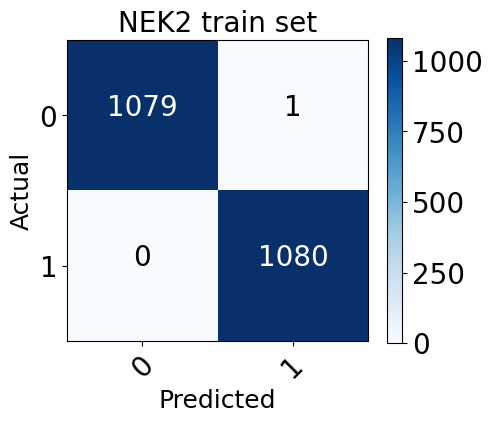

In [52]:
train_y_true = train_y_df.values
train_y_pred = train_pred
train_cm = confusion_matrix(train_y_true, train_y_pred)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [53]:
# Make predictions 
test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)



prediction means shape: (2, 283)
class predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1])


In [54]:
test_pred.shape
test_x.shape

torch.Size([283, 306])

slightly different output than Yaru's tutorial

In [55]:
indices = np.where(test_pred == 1)[0]
# indices # array([136, 146, 273, 276, 282]) compared to: 
# tutorial: array([125, 136, 146, 273, 276, 282]) 

Confusion matrix, without normalization
[[269   2]
 [  9   3]]
accuracy: 0.9611307420494699, precision: 0.6, f1: 0.35294117647058826, recall: 0.25


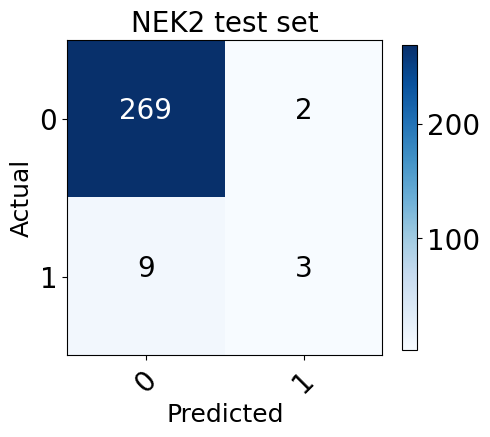

In [56]:
test_y_true = test_y_df.values.flatten()
test_y_pred = test_pred
test_cm = confusion_matrix(test_y_true, test_y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);
test_accuracy, test_precision, test_f1, test_recall = trainer1.get_metrics(test_x, test_y, test_pred)
print(f'accuracy: {test_accuracy}, precision: {test_precision}, f1: {test_f1}, recall: {test_recall}')

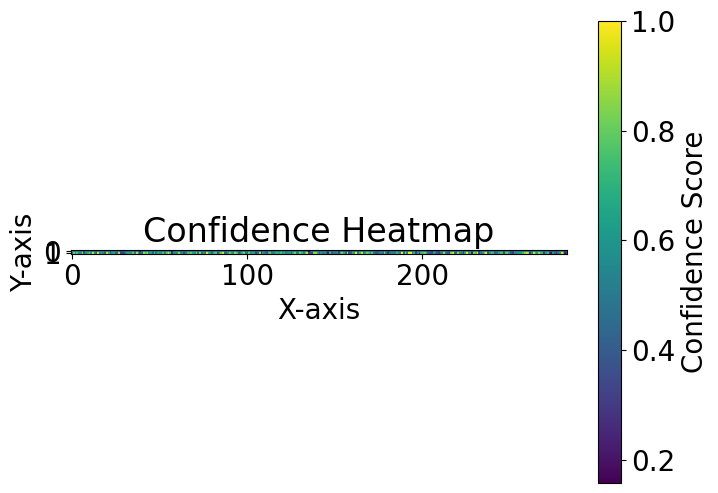

In [57]:
dist = trainer1.model(test_x)
pred_varainces = dist.variance
normalized = pred_varainces/pred_varainces.max() 
normalized.shape
plt.figure(figsize=(8, 6))
plt.imshow(normalized.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Confidence Score')
plt.title('Confidence Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [22]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
# pred_means = dist.loc
test_pred_variance2D = test_observed_pred.variance.numpy()
print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D

(2, 283)


array([[1.6695974, 1.9118346, 1.8655758, 1.8903551, 1.7402596, 1.7774752,
        1.9285194, 1.430552 , 1.7309384, 1.8996766, 1.8891149, 1.8296678,
        1.9304178, 1.8214409, 1.4581081, 1.932944 , 1.7140485, 1.7784915,
        1.7184273, 1.541692 , 1.9281502, 1.8492732, 1.4269274, 1.7837483,
        1.8536267, 1.5428833, 1.600152 , 1.9209682, 1.3191164, 1.3120883,
        1.3560736, 1.757245 , 1.8919804, 1.8633183, 1.8379686, 1.8967144,
        1.7467607, 1.9278703, 1.8430588, 1.4359412, 1.5532389, 1.9206254,
        1.8812894, 1.9276047, 1.8424377, 1.8128034, 1.516912 , 1.8731664,
        1.6790231, 1.8927683, 1.7554008, 1.8349802, 1.9014114, 1.7135286,
        1.8993735, 1.9331666, 1.8841648, 1.1290586, 1.7674334, 1.7572459,
        1.7704068, 1.9294516, 1.8170291, 1.8062088, 1.3443815, 1.8163428,
        1.9183005, 1.8834944, 1.9067752, 1.7476397, 1.7594925, 1.9285804,
        1.6473722, 1.9166251, 1.5851972, 1.7826202, 1.7193274, 1.9332334,
        1.8646411, 1.904968 , 1.598533

In [58]:
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
print(var_min, var_max)

0.981158 3.0811598


In [59]:
# Training set variance
print(train_observed_pred.variance.numpy().shape)
train_observed_pred.variance.numpy()

(2, 2160)


array([[2.5988598, 2.3962703, 2.5651402, ..., 5.6206365, 5.6604824,
        5.493429 ],
       [7.65549  , 6.59887  , 7.104254 , ..., 1.6922333, 1.6731927,
        1.6042862]], dtype=float32)

In [83]:
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]
len(test_pred_variance)
reshaped_pred_var = test_pred_variance2D
reshaped_pred_var.shape
test_x.shape, test_y.shape

(torch.Size([283, 306]), torch.Size([283]))

In [ ]:
# calibratio
from sklearn.calibration import calibration_curve
# n_bins = 10
# prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

# plt.figure(figsize=(8, 6))
# plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
# plt.xlabel('Predicted Probability')
# plt.ylabel('True Frequency')
# plt.title('Calibration Plot')
# plt.grid(True)
# plt.show(); 


In [106]:
with torch.no_grad(): 
    test_dist = model1(test_x)
    pred_means = test_dist.mean 
    pred_var = test_dist.variance
print(pred_var.shape)
# pred_var_reshaped = pred_var.reshape(2, -1)
# pred_var_reshaped.shape
pred_var[1]

torch.Size([2, 283])


tensor([1.5688, 2.4935, 1.9556, 2.3746, 1.7485, 1.8120, 2.6195, 1.2209, 1.8731,
        2.1347, 2.4254, 1.9020, 2.8442, 1.7194, 1.2439, 2.9575, 1.7811, 1.8839,
        1.7274, 1.2929, 2.8451, 2.1638, 1.1712, 1.9313, 2.0314, 1.4009, 1.4595,
        2.7196, 0.9793, 0.9650, 1.0740, 1.7110, 2.0626, 1.9474, 1.8730, 2.4262,
        1.5445, 2.7886, 2.0072, 1.1765, 1.3360, 2.6370, 2.3669, 2.7873, 1.8245,
        2.0399, 1.2812, 2.2885, 1.4873, 2.1069, 1.9096, 1.8491, 2.3267, 1.6301,
        2.4575, 2.9813, 2.3059, 0.8565, 1.7690, 1.8818, 1.8391, 2.6609, 1.6651,
        1.9188, 1.0382, 1.5946, 2.3232, 2.2673, 2.4519, 2.0414, 1.8258, 2.5800,
        1.4899, 2.5863, 1.4146, 1.9821, 1.5653, 3.0152, 2.1508, 1.9404, 1.3588,
        2.2176, 2.4016, 1.2055, 2.0534, 2.4142, 2.9679, 1.4284, 1.3663, 1.9124,
        2.4623, 1.9498, 1.6420, 2.6800, 2.3336, 1.2844, 1.5149, 2.1379, 2.5767,
        1.4094, 1.4818, 2.4350, 1.8288, 2.0906, 1.9171, 1.0128, 1.4299, 2.7489,
        0.8630, 1.8887, 1.5276, 1.2306, 

torch.Size([283, 283])
tensor([[1.4981, 1.4981, 1.4981,  ..., 1.4981, 1.4981, 1.4981],
        [1.8439, 1.8439, 1.8439,  ..., 1.8439, 1.8439, 1.8439],
        [1.5834, 1.5834, 1.5834,  ..., 1.5834, 1.5834, 1.5834],
        ...,
        [1.8038, 1.8038, 1.8038,  ..., 1.8038, 1.8038, 1.8038],
        [0.8388, 0.8388, 0.8388,  ..., 0.8388, 0.8388, 0.8388],
        [1.1646, 1.1646, 1.1646,  ..., 1.1646, 1.1646, 1.1646]])
torch.Size([283, 283])
tensor([[1.5688, 1.5688, 1.5688,  ..., 1.5688, 1.5688, 1.5688],
        [2.4935, 2.4935, 2.4935,  ..., 2.4935, 2.4935, 2.4935],
        [1.9556, 1.9556, 1.9556,  ..., 1.9556, 1.9556, 1.9556],
        ...,
        [2.3022, 2.3022, 2.3022,  ..., 2.3022, 2.3022, 2.3022],
        [0.6875, 0.6875, 0.6875,  ..., 0.6875, 0.6875, 0.6875],
        [1.0002, 1.0002, 1.0002,  ..., 1.0002, 1.0002, 1.0002]])


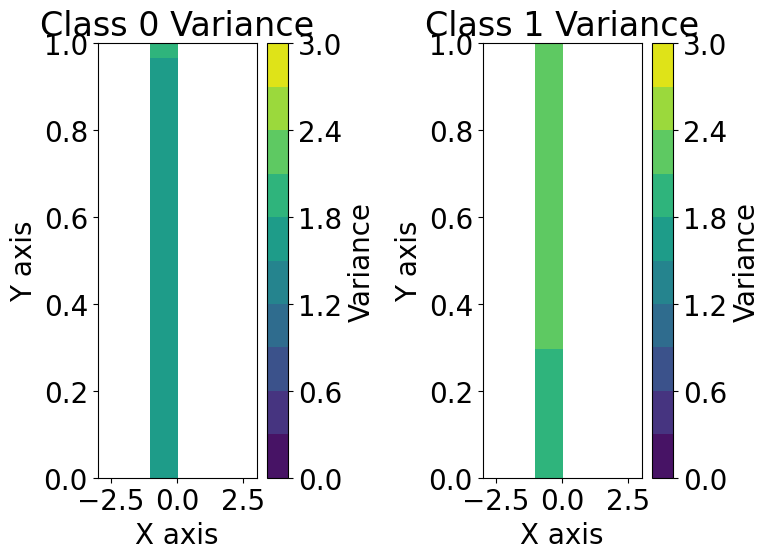

In [107]:
levels = np.linspace(0, 3, 11)
plt.figure(figsize=(8, 6))

x_values = test_x[:, 0].numpy()
y_values = test_y.numpy()
# y = np.linspace(test_y.min(), test_y.max(), 283)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

for class_idx in range(2):
    plt.subplot(1, 2, class_idx + 1)
    pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
    # print(pred_var_copy)
    # pred_var_reshaped = pred_var_copy.reshape((2, 283, 283))
    # plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

    pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
    # pred_var_copy = np.repeat(pred_var_copy[:, :, np.newaxis], x_mesh.shape[1], axis=2)
    print(pred_var_copy.shape)
    print(pred_var_copy)
    plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

    plt.colorbar(label='Variance')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f'Class {class_idx} Variance')


plt.tight_layout()
plt.show();


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65491/1115159247.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(np.arange(len(test_y_true)), test_pred, test_pred_variance, cmap='viridis')


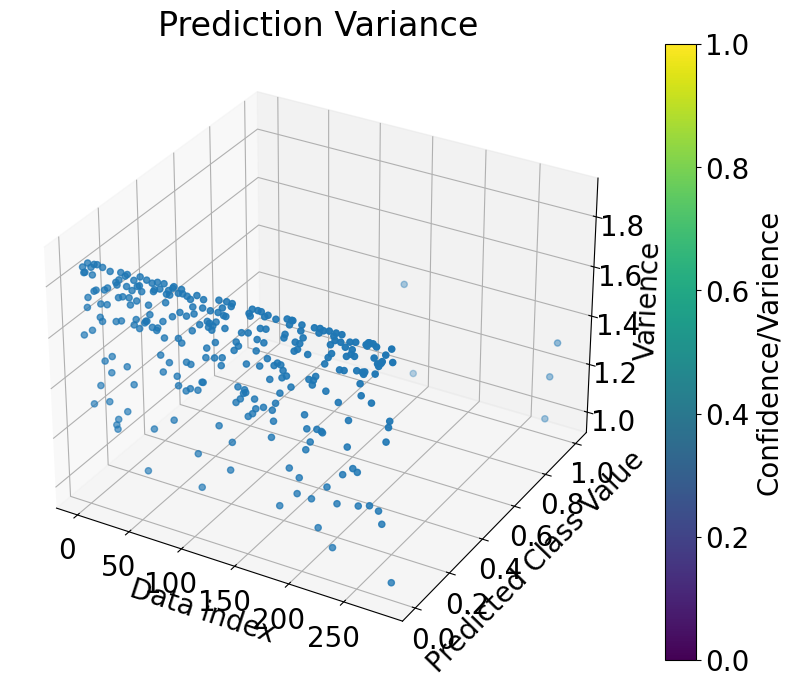

In [175]:
# scatter 3d? 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(np.arange(len(test_y_true)), test_pred, test_pred_variance, cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Confidence/Varience')

ax.set_xlabel('Data index')
ax.set_ylabel('Predicted Class Value')
ax.set_zlabel('Varience')
ax.set_title('Prediction Variance')
plt.show();


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65491/3516929116.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


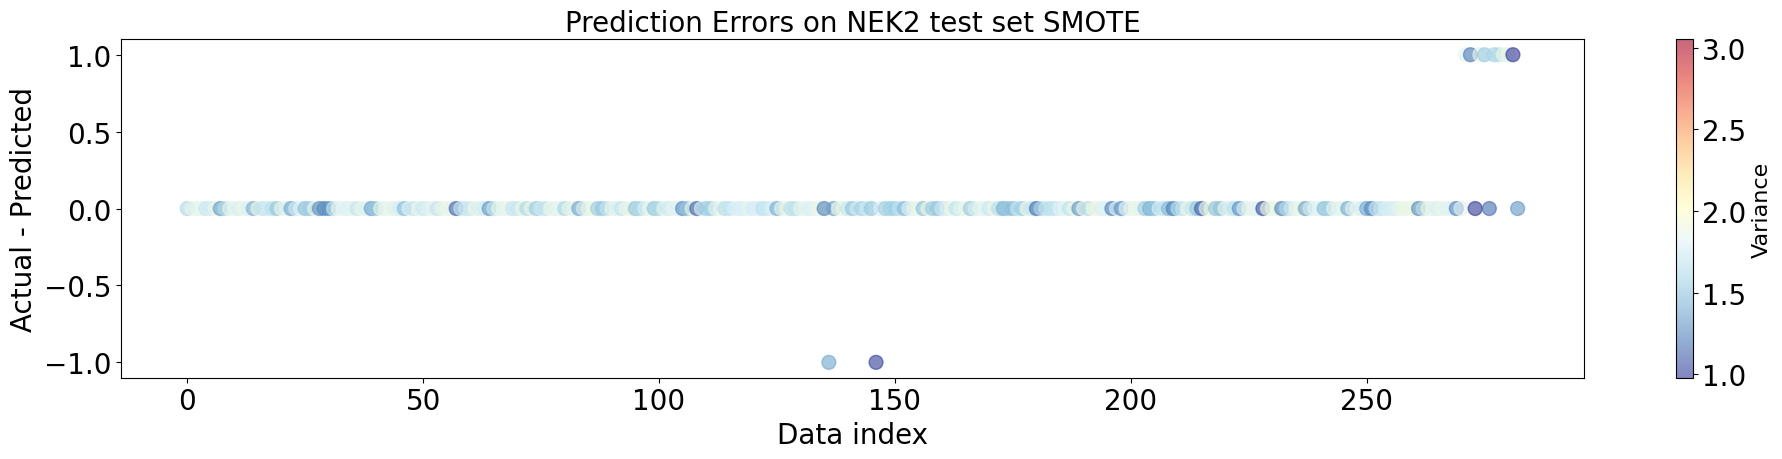

In [101]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y_true)),(test_y_true - test_pred), c=test_pred_variance, s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65491/469887754.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


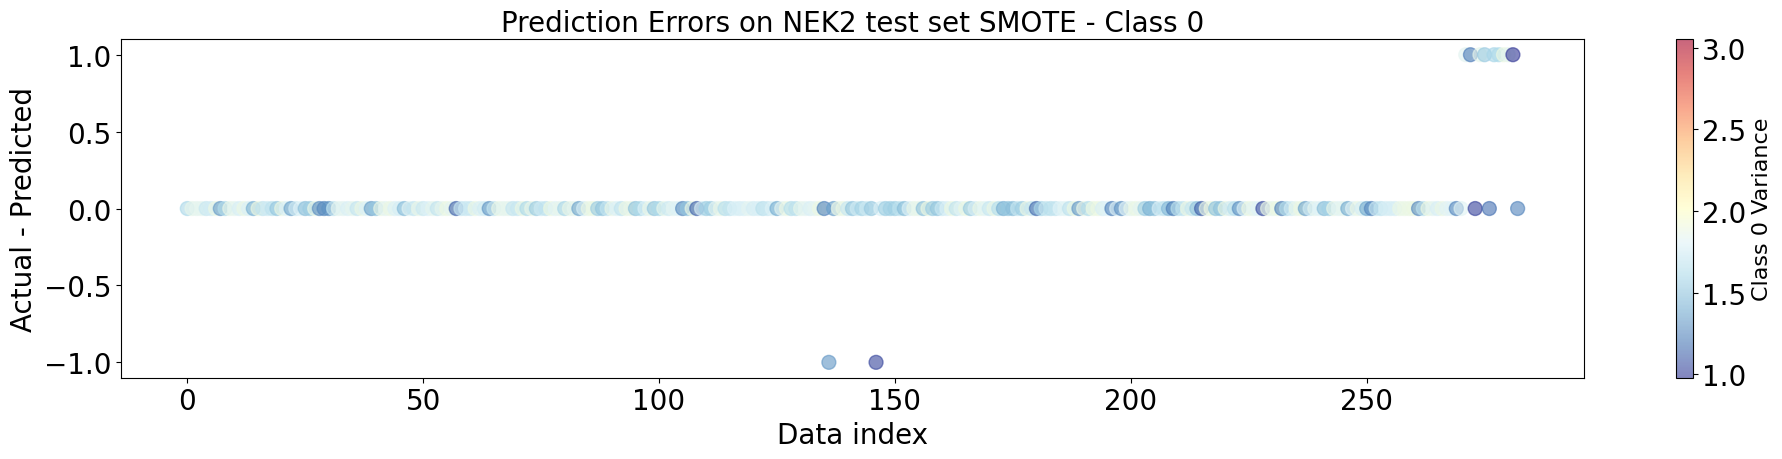

In [154]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 0",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y_true)),(test_y_true - test_pred), c=test_pred_variance2D[0], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 0 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65491/328263263.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


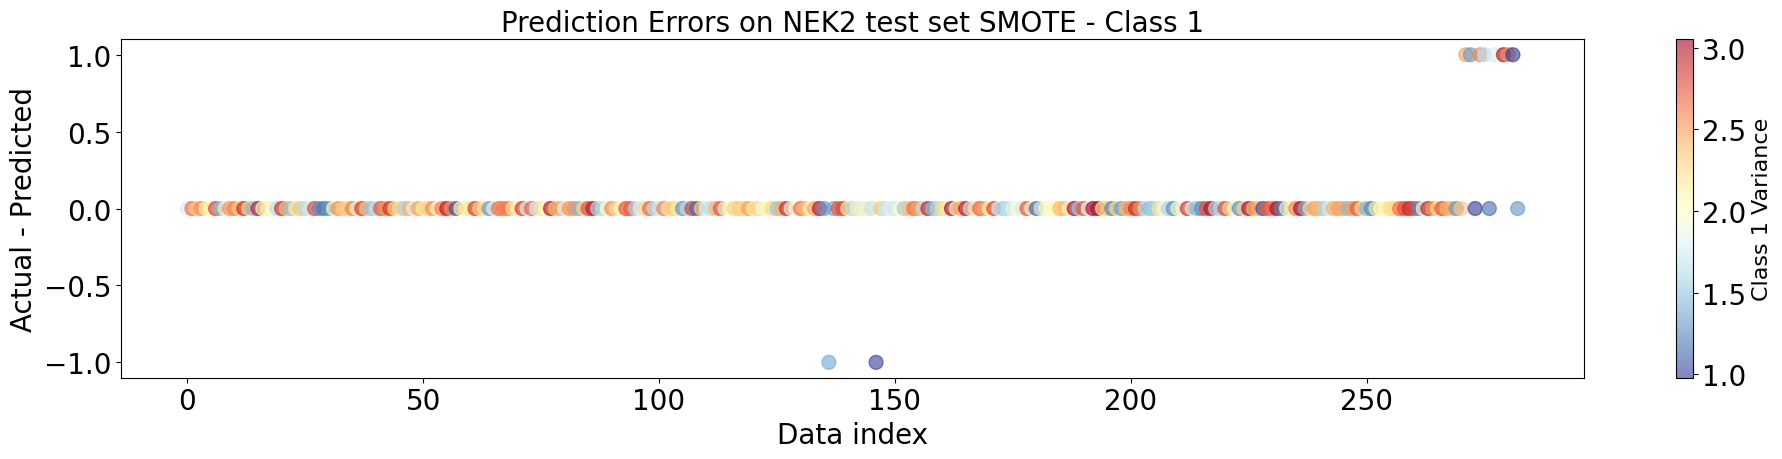

In [155]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 1",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y_true)),(test_y_true - test_pred), c=test_pred_variance2D[1], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 1 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()